# [**SDMX1**](https://pypi.org/project/sdmx1/)

- https://sebastianpaulo.net/blog/working-with-data-from-official-providers-a-brief-tour-of-pandasdmx/

sdmxl is the name used on PyPI (because sdmx was already taken, by a package that's unmaintained). 
So to install, e.g. pip install sdmx1. 
Once installed, use import sdmx instead of import pandasdmx

In [1]:
import sdmx # pip install sdmx1
istat = sdmx.Request("ISTAT")

## Elenco DataFlow Istat

In [3]:
flow_msg = istat.dataflow() #We use sdmx to download the definitions for all data flows available from our chosen source. 

In [3]:
print(flow_msg.response.url) # see the URL that was queried 

https://esploradati.istat.it/SDMXWS/rest/dataflow/all/all/latest


In [4]:
print(flow_msg.response.headers) # see the response headers

{'Cache-Control': 'no-store,no-cache', 'Pragma': 'no-cache', 'Transfer-Encoding': 'chunked', 'Content-Type': 'application/vnd.sdmx.structure+xml; charset=utf-8; version=2.1', 'Accept-Ranges': 'values', 'Vary': 'Accept,Accept-Encoding', 'Server': 'Microsoft-IIS/10.0, IIS', 'Strict-Transport-Security': 'max-age=2592000, max-age=31536000; includeSubDomains; preload', 'api-supported-versions': '1', 'X-XSS-Protection': '1; mode=block', 'X-Frame-Options': 'ALLOW-FROM https://*.istat.it', 'X-Content-Type-Options': 'nosniff', 'X-Powered-By': 'ASP.NET', 'Server-Timing': 'dtSInfo;desc="0", dtRpid;desc="1632953904"', 'Set-Cookie': 'dtCookie=v_4_srv_8_sn_79EC6C3FA410314755803A100B003600_perc_100000_ol_0_mul_1_app-3A521fadc1a45e0215_1; Path=/; Domain=.istat.it', 'Date': 'Sun, 06 Jul 2025 16:57:32 GMT'}


In [5]:
print(flow_msg) #All the content of the response—SDMX data and metadata objects—has been parsed and is accessible from flow_msg. Let’s find out what we have received

<sdmx.StructureMessage>
  <Header>
    id: 'IDREF618'
    prepared: '2025-07-06T18:57:32.816684+02:00'
    receiver: <Agency Unknown>
    sender: <Agency Unknown>
    source: 
    test: False
  response: <Response [200]>
  DataflowDefinition (3961): 101_1015 101_1015_DF_DCSP_COLTIVAZIONI_1 1...
  DataStructureDefinition (756): DCSP_COLTIVAZIONI DCSP_DOPIGP DCSP_MAC...


In [9]:
dataflows = sdmx.to_pandas(flow_msg.dataflow)
type(dataflows)

pandas.core.series.Series

In [10]:
print("The file contains", len(dataflows), "data flow definitions")

The file contains 3962 data flow definitions


In [11]:
dataflows.head() # sdmx.to_pandas(estat.dataflow).head()

101_1015                                                                      Crops
101_1015_DF_DCSP_COLTIVAZIONI_1                 Areas and production - overall data
101_1015_DF_DCSP_COLTIVAZIONI_10                                    Sowing forecast
101_1015_DF_DCSP_COLTIVAZIONI_2     Areas and production - overall data - provinces
101_1030                                          PDO, PGI and TSG quality products
dtype: object

In [12]:
dataflows = sdmx.to_pandas(flow_msg.dataflow) # converting metadata to pandas.Series
print(dataflows.head())

101_1015                                                                      Crops
101_1015_DF_DCSP_COLTIVAZIONI_1                 Areas and production - overall data
101_1015_DF_DCSP_COLTIVAZIONI_10                                    Sowing forecast
101_1015_DF_DCSP_COLTIVAZIONI_2     Areas and production - overall data - provinces
101_1030                                          PDO, PGI and TSG quality products
dtype: object


In [13]:
dataflows.columns

AttributeError: 'Series' object has no attribute 'columns'

In [14]:
dataflows[dataflows.str.contains('139_176', case=False)] # True = case sensitive

Series([], dtype: object)

## estrazione diretta

In [15]:
from sdmx import Client

# Inizializza il client ISTAT
istat = Client("Istat")

# STEP 1 – Carica il dataflow e ottieni la struttura associata
df_id = "139_176"
dataflows = istat.dataflow()
df = dataflows.dataflow[df_id]

# Nome leggibile robusto
if df.name.localizations:
    nome_df = (
        df.name.localizations.get("it") or
        df.name.localizations.get("en") or
        next(iter(df.name.localizations.values()))
    )
else:
    nome_df = str(df.name)

print(f"\n🧩 Dataflow ID: {df.id}")
print(f"📘 Nome: {nome_df}")
print(f"📎 DSD ID: {df.structure.id}")


🧩 Dataflow ID: 139_176
📘 Nome: Importazioni ed esportazioni per paese e merce Ateco 2007
📎 DSD ID: DCSP_COEIMPEX1


In [16]:
# STEP 2 – Scarica la struttura dati
dsd_msg = istat.datastructure(df.structure.id)
dsd = dsd_msg.structure[0]


In [17]:
# STEP 3 – Elenca dimensioni e codelist associate
print("\n📐 Dimensioni e relative Codelist:")
for dim in dsd.dimensions:
    cl = dim.local_representation.enumerated
    cl_id = cl.id if cl else "—"
    print(f" - {dim.id} → {cl_id}")


📐 Dimensioni e relative Codelist:
 - FREQ → CL_FREQ
 - REF_AREA → CL_COEWEB_ITTER107
 - DATA_TYPE → CL_COEWEB_TIPO_DATO_COEIMPEX
 - CPA_ATECO2007_COE → CL_COEWEB_ATECO_2007_MERCE
 - PARTNER_COUNTRY → CL_COEWEB_GEONOM
 - TIME_PERIOD → —


In [22]:
# STEP 4 – Elenca i valori ammessi per ciascuna codelist
print("\n📋 Contenuto delle Codelist:")
codelists = dsd_msg.codelist

for dim in dsd.dimensions:
    cl = dim.local_representation.enumerated
    cl_id = cl.id if cl else None
    if cl_id and cl_id in codelists:
        print(f"\n🔹 {dim.id} ({cl_id}):")
        for code in codelists[cl_id]:
            if code.name.localizations:
                label = (
                    code.name.localizations.get("it") or
                    code.name.localizations.get("en") or
                    next(iter(code.name.localizations.values()))
                )
            else:
                label = ""
            print(f"   - {code.id:<15} {label}")




📋 Contenuto delle Codelist:

🔹 FREQ (CL_FREQ):
   - A               annuale
   - B               business (non supportato)
   - D               giornaliero
   - E               event (non supportato)
   - H               semestrale
   - M               mensile
   - Q               trimestrale
   - W               settimanale

🔹 REF_AREA (CL_ITTER107):
   - 00              Raggruppamento a 107 province
   - IT              Italia
   - ITCDE           Centro-nord
   - ITCD            Nord
   - N_2             centro area metropolitana
   - N_MET_AR_INH_GE50001 periferia area metropolitana e comuni con 50.001 ab. e più
   - N_INH_OTH_UN5000 altri comuni fino a 50.000 ab. (diversi dai comuni periferia area metropolitana)
   - ITC             Nord-ovest
   - ITC1            Piemonte
   - ITC11           Torino
   - 001001          Agliè
   - 001002          Airasca
   - 001003          Ala di Stura
   - 001004          Albiano d'Ivrea
   - 001005          Alice Superiore
   - 001006       

In [25]:
import sdmx
import pandas as pd

# Inizializza client SDMX ISTAT
istat = sdmx.Client("Istat")

# Query con dimensioni corrette
key = dict(
    FREQ="A",
    REF_AREA="IT+ITC+ITD+ITE+ITF+ITG",
    DATA_TYPE_AGGR="B1G_B_W2_S1_R_PS",
    VALUATION="V",
    EDITION="2023M12"
)
params = dict(startPeriod="2010", endPeriod="2022")

# Richiesta dati
data_msg = istat.data("93_500", key=key, params=params)

# Estrai il dataset dal messaggio
data = data_msg.data[0]

# Converte in DataFrame long
df_long = sdmx.to_pandas(data)
print("📌 Livelli di indicizzazione:", df_long.index.names)

# Filtro + pivot per TIME_PERIOD come colonne
df_wide = (
    df_long
    .xs(("B1G_B_W2_S1_R_PS", "V", "2023M12"), level=("DATA_TYPE_AGGR", "VALUATION", "EDITION"))
    .unstack(level="TIME_PERIOD")
)

print(df_wide)




📌 Livelli di indicizzazione: ['FREQ', 'REF_AREA', 'DATA_TYPE_AGGR', 'BRKDW_INDUSTRY_NACE_REV2', 'NONFIN_ASSETS', 'EXPEND_PURPOSE_COICOPCOFOG', 'VALUATION', 'ADJUSTMENT', 'PRICE', 'EDITION', 'TIME_PERIOD']
TIME_PERIOD                                                                                            2010  \
FREQ REF_AREA BRKDW_INDUSTRY_NACE_REV2 NONFIN_ASSETS EXPEND_PURPOSE_COICOPCOFOG ADJUSTMENT PRICE              
A    IT       Z                        Z             Z                          N          Z      58485.337   
     ITC      Z                        Z             Z                          N          Z      65307.526   
     ITD      Z                        Z             Z                          N          Z      59842.372   
     ITE      Z                        Z             Z                          N          Z      60344.234   
     ITF      Z                        Z             Z                          N          Z      48602.098   
     ITG      Z   

C:\Users\paolo\AppData\Local\Temp\ipykernel_25300\1858461043.py:11: MatplotlibDeprecationWarning: Passing label as a length 7 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(df_wide.columns, df_wide.loc[area], marker="o", label=area)


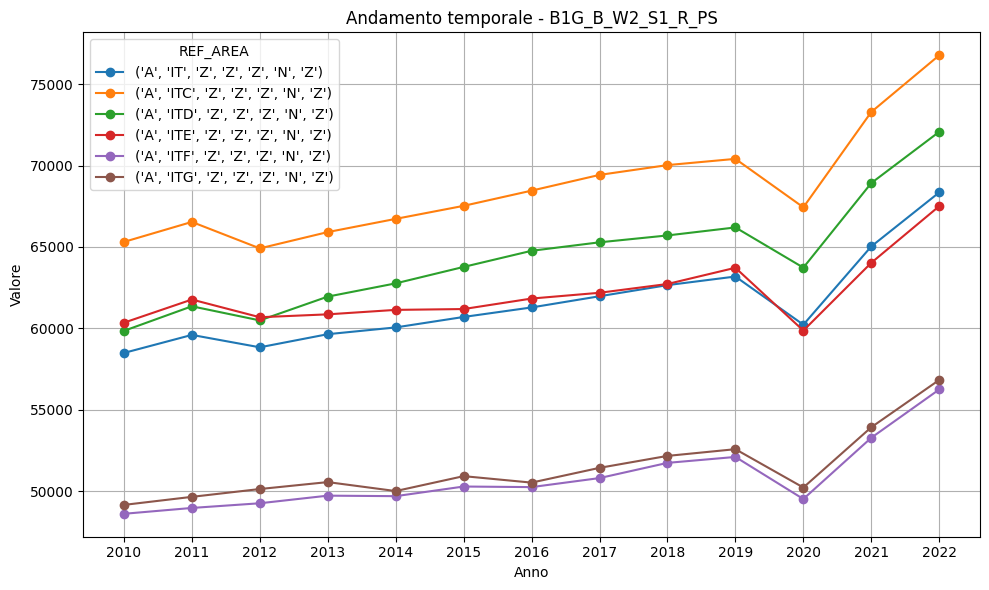

In [26]:
import matplotlib.pyplot as plt

# Assumiamo che df_wide sia già definito come nel passaggio precedente

# Rendi leggibili gli anni nell'intestazione
df_wide.columns = df_wide.columns.get_level_values("TIME_PERIOD")

# Plot
plt.figure(figsize=(10, 6))
for area in df_wide.index:
    plt.plot(df_wide.columns, df_wide.loc[area], marker="o", label=area)

plt.title("Andamento temporale - B1G_B_W2_S1_R_PS")
plt.xlabel("Anno")
plt.ylabel("Valore")
plt.grid(True)
plt.legend(title="REF_AREA")
plt.tight_layout()
plt.show()


C:\Users\paolo\AppData\Local\Temp\ipykernel_25300\2511859279.py:43: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(df_pivot.columns, df_pivot.loc[area], marker="o", label=area)


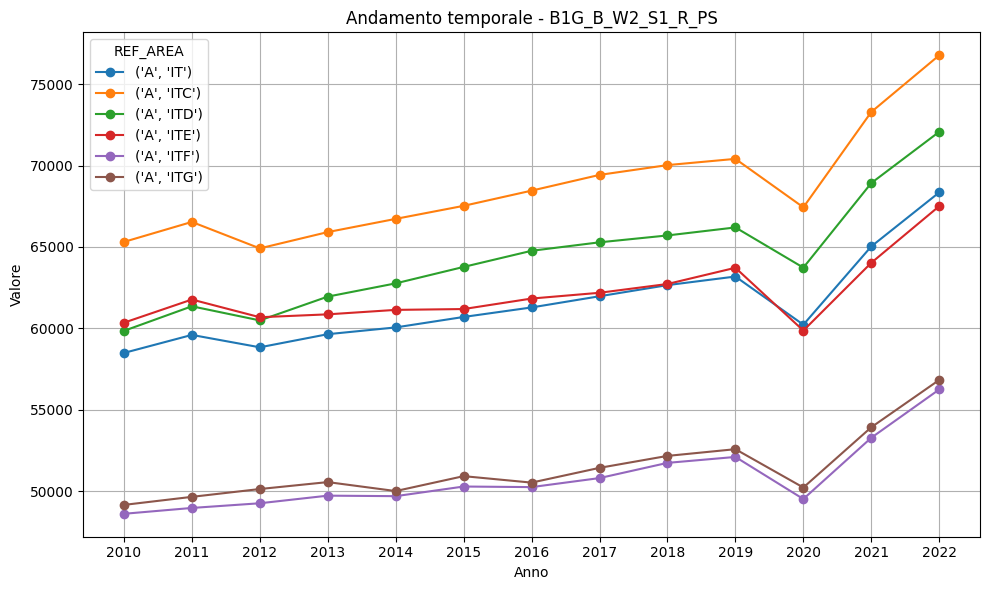

In [27]:
import sdmx
import pandas as pd
import matplotlib.pyplot as plt

istat = sdmx.Client('Istat')

# Parametri corretti
key = dict(
    FREQ="A",
    REF_AREA="IT+ITC+ITD+ITE+ITF+ITG",
    DATA_TYPE_AGGR="B1G_B_W2_S1_R_PS",
    VALUATION='V',
    EDITION='2023M12'
)
params = dict(startPeriod='2010', endPeriod='2022')

# Scarica dati
data_msg = istat.data('93_500', key=key, params=params)
data = data_msg.data[0]

# Converti in DataFrame long
df_long = sdmx.to_pandas(data)

# Filtro completo con tutte le dimensioni
df_filtered = df_long.xs(
    key=("B1G_B_W2_S1_R_PS", "V", "2023M12", "N", "Z", "Z", "Z", "Z"),
    level=(
        "DATA_TYPE_AGGR", "VALUATION", "EDITION",
        "ADJUSTMENT", "BRKDW_INDUSTRY_NACE_REV2",
        "EXPEND_PURPOSE_COICOPCOFOG", "NONFIN_ASSETS", "PRICE"
    )
)

# Pivot con TIME_PERIOD come colonne
df_pivot = df_filtered.unstack(level="TIME_PERIOD")

# Rinomina colonne
df_pivot.columns = df_pivot.columns.get_level_values("TIME_PERIOD")

# Plot
plt.figure(figsize=(10, 6))
for area in df_pivot.index:
    plt.plot(df_pivot.columns, df_pivot.loc[area], marker="o", label=area)

plt.title("Andamento temporale - B1G_B_W2_S1_R_PS")
plt.xlabel("Anno")
plt.ylabel("Valore")
plt.grid(True)
plt.legend(title="REF_AREA")
plt.tight_layout()
plt.show()


In [29]:
import sdmx
import pandas as pd

# Inizializza client
istat = sdmx.Client('Istat')

# Query SDMX corretta
key = dict(
    FREQ="A",
    REF_AREA="IT",
    VALUATION='V',
    EDITION='2023M12'
)
params = dict(startPeriod='2010', endPeriod='2023')

# Scarica i dati
data_msg = istat.data('93_500', key=key, params=params)
data = data_msg.data[0]

# Converte in DataFrame long
df_long = sdmx.to_pandas(data)

# Filtro con xs
df_final = df_long.xs(
    key=("V", "2023M12", "Z", "N", "Z", "Z", "Z"),
    level=("VALUATION", "EDITION", "BRKDW_INDUSTRY_NACE_REV2",
           "ADJUSTMENT", "EXPEND_PURPOSE_COICOPCOFOG", "NONFIN_ASSETS", "PRICE")
)

# Output
print(df_final)


FREQ  REF_AREA  DATA_TYPE_AGGR    TIME_PERIOD
A     IT        B1G_B_W2_S1_R_FT  2010           60096.209
                                  2011           61347.300
                                  2012           61210.120
                                  2013           62458.658
                                  2014           62821.337
                                                   ...    
                P3_D_W2_S1_R_POP  2017           23213.405
                                  2018           23746.180
                                  2019           23969.445
                                  2020           22160.917
                                  2021           23617.627
Name: value, Length: 161, dtype: float64


In [30]:
data_df2 = sdmx.to_pandas(
        data,
        datetime={
                'dim': 'TIME_PERIOD',
                'freq': 'FREQ',
                'axis': 1
            }
    )
data_df2

c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdmx\writer\pandas.py:481: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  df.index = df.index.to_period(freq=freq)


TIME_PERIOD                                                                                                                        2010  \
REF_AREA DATA_TYPE_AGGR BRKDW_INDUSTRY_NACE_REV2 NONFIN_ASSETS EXPEND_PURPOSE_COICOPCOFOG VALUATION ADJUSTMENT PRICE EDITION              
IT       B1G_B_W2_S1    _T                       Z             Z                          V         N          B     2023M12  1449430.4   
                        A                        Z             Z                          V         N          B     2023M12    28608.5   
                        A01_02                   Z             Z                          V         N          B     2023M12    27233.2   
                        A03                      Z             Z                          V         N          B     2023M12     1375.2   
                        B                        Z             Z                          V         N          B     2023M12     4520.0   
...                                                                                                                                 ...   
         P51G_D_W2_S1   Q                        N11           Z                          V         N          Z     2023M12     9709.4   
                        R                        N11           Z                          V         N          Z     2023M12     3291.7   
                        RTU                      N11           Z                          V         N          Z     2023M12     5138.4   
                        S                        N11           Z                          V         N          Z     2023M12     1846.7   
                        T                        N11           Z                          V         N          Z     2023M12        0.0   

TIME_PERIOD                                                                                                                        2011  \
REF_AREA DATA_TYPE_AGGR BRKDW_INDUSTRY_NACE_REV2 NONFIN_ASSETS EXPEND_PURPOSE_COICOPCOFOG VALUATION ADJUSTMENT PRICE EDITION              
IT       B1G_B_W2_S1    _T                       Z             Z                          V         N          B     2023M12  1480874.7   
                        A                        Z             Z                          V         N          B     2023M12    31053.1   
                        A01_02                   Z             Z                          V         N          B     2023M12    29738.9   
                        A03                      Z             Z                          V         N          B     2023M12     1314.2   
                        B                        Z             Z                          V         N          B     2023M12     5369.8   
...                                                                                                                                 ...   
         P51G_D_W2_S1   Q                        N11           Z                          V         N          Z     2023M12     8596.7   
                        R                        N11           Z                          V         N          Z     2023M12     3389.2   
                        RTU                      N11           Z                          V         N          Z     2023M12     5300.1   
                        S                        N11           Z                          V         N          Z     2023M12     1910.9   
                        T                        N11           Z                          V         N          Z     2023M12        0.0   

TIME_PERIOD                                                                                                                        2012  \
REF_AREA DATA_TYPE_AGGR BRKDW_INDUSTRY_NACE_REV2 NONFIN_ASSETS EXPEND_PURPOSE_COICOPCOFOG VALUATION ADJUSTMENT PRICE EDITION              
IT       B1G_B_W2_S1    _T                       Z             Z                          V         N     

In [31]:
import sdmx
import pandas as pd

# Client e query
istat = sdmx.Client('Istat')
key = dict(
    FREQ="A",
    REF_AREA="IT",
    VALUATION='V',
    EDITION='2023M12'
)
params = dict(startPeriod='2010', endPeriod='2023')
data_msg = istat.data('93_500', key=key, params=params)
data = data_msg.data[0]

# Converti in DataFrame long
df_long = sdmx.to_pandas(data)

# Opzionale: filtro sulle dimensioni se necessario
df_filtered = df_long.xs(
    key=("Z", "N", "Z", "Z", "Z"),
    level=("BRKDW_INDUSTRY_NACE_REV2", "ADJUSTMENT", "EXPEND_PURPOSE_COICOPCOFOG", "NONFIN_ASSETS", "PRICE")
)

# Pivot con TIME_PERIOD come colonne (formato "wide")
df_wide = df_filtered.unstack(level="TIME_PERIOD")
df_wide.columns = df_wide.columns.get_level_values("TIME_PERIOD")

# Risultato
print(df_wide)


TIME_PERIOD                                               2010       2011  \
FREQ REF_AREA DATA_TYPE_AGGR      VALUATION EDITION                         
A    IT       B1G_B_W2_S1_R_FT    V         2023M12  60096.209  61347.300   
              B1G_B_W2_S1_R_HW    V         2023M12     32.917     33.620   
              B1G_B_W2_S1_R_POP   V         2023M12  24230.106  24670.226   
              B1G_B_W2_S1_R_PS    V         2023M12  58485.337  59593.264   
              B1GQ_B_W2_S1_R_POP  V         2023M12  26935.733  27466.994   
              B6G_B_W2_S14A_R_POP V         2023M12  17680.185  18076.971   
              D1_D_W2_S1_R_FT     V         2023M12  38741.977  39193.562   
              D1_D_W2_S1_R_HW     V         2023M12     21.662     21.887   
              D1_D_W2_S1_R_PS     V         2023M12  35000.588  35342.138   
              D11_D_W2_S1_R_FT    V         2023M12  28160.526  28493.806   
              D11_D_W2_S1_R_HW    V         2023M12     15.746     15.912   

## 93_500 DataFlow ID - Principali aggregati territoriali di Contabilità Nazionale

- P3_D_W2_S1_R_POP	consumi finali interni per abitante
- B1GQ_B_W2_S1_R_POP	prodotto interno lordo ai prezzi di mercato per abitante
- D1_D_W2_S1_R_PS	redditi interni da lavoro dipendente per occupato dipendente
- D1_D_W2_S1_R_HW	redditi interni da lavoro dipendente per ora lavorata da occupato dipendente
- D1_D_W2_S1_R_FT	redditi interni da lavoro dipendente per unità di lavoro dipendente
- B6G_B_W2_S14A_R_POP	reddito disponibile delle famiglie consumarici per abitante
- D11_D_W2_S1_R_PS	retribuzioni interne lorde per occupato dipendente
- D11_D_W2_S1_R_HW	retribuzioni interne lorde per ora lavorata da occupato dipendente
- D11_D_W2_S1_R_FT	retribuzioni interne lorde per unità di lavoro dipendente
- B1G_B_W2_S1_R_POP	valore aggiunto per abitante
- **B1G_B_W2_S1_R_PS	valore aggiunto per occupato**
- B1G_B_W2_S1_R_HW	valore aggiunto per ora lavorata
- B1G_B_W2_S1_R_FT	valore aggiunto per unità di lavoro


- creiamo un Client che utilizzeremo per effettuare più query al servizio web SDMX-REST di questo provider:
- scarichiamo un messaggio di struttura contenente il DSD e altre informazioni strutturali a cui fa riferimento. Questi includono metadati strutturali che insieme descrivono completamente i dati disponibili attraverso questo flusso di dati: concetti, elementi misurati, dimensioni, elenchi di codici utilizzati per etichettare ciascuna dimensione, attributi e così via

In [32]:
istat = sdmx.Client("ISTAT")
flow_msg  = istat.dataflow('93_500')
dfd = flow_msg.dataflow['93_500']
dfd

<DataflowDefinition IT1:93_500(1.0): National Accounts regional main aggregates - editions from January 2020 to December 2023>

In [33]:
flow_msg

<sdmx.StructureMessage>
  <Header>
    id: 'IDREF637'
    prepared: '2025-07-06T19:13:07.600861+02:00'
    receiver: <Agency Unknown>
    sender: <Agency Unknown>
    source: 
    test: False
  response: <Response [200]>
  Categorisation (1): CAT_93_500_76353
  CategoryScheme (1): SEP
  Codelist (38): CL_BASE_YEAR CL_BRANCA_ATTIVITAREV2 CL_CONTAB_NOTE CL_...
  ConceptScheme (2): CONTAB_DOMAIN CROSS_DOMAIN
  DataflowDefinition (1): 93_500
  DataStructureDefinition (1): DCCN_TNA

In [34]:
flow_msg.structure 

{'DCCN_TNA': <DataStructureDefinition IT1:DCCN_TNA(1.0): National Accounts regional main aggregates>}

In [35]:
dfd.structure 

<DataStructureDefinition IT1:DCCN_TNA(1.0): National Accounts regional main aggregates>

In [36]:
flow_msg.structure 

{'DCCN_TNA': <DataStructureDefinition IT1:DCCN_TNA(1.0): National Accounts regional main aggregates>}

In [37]:
dsd = flow_msg.structure 
print(dsd) # Show the data structure definition referred to by the data flow

{'DCCN_TNA': <DataStructureDefinition IT1:DCCN_TNA(1.0): National Accounts regional main aggregates>}


In [38]:
flow_msg.codelist.CL_BRANCA_ATTIVITAREV2.items

{'V': <Code V: total economic activities>,
 'VNM': <Code VNM: non market economic activities>,
 'VA': <Code VA: agriculture, forestry and fishing>,
 'V01_02': <Code V01_02: crop and animal production, hunting and related service activities, forestry>,
 'V01': <Code V01: crop and animal production, hunting and related service activities>,
 'V02': <Code V02: forestry and logging>,
 'V03': <Code V03: fishing and aquaculture>,
 'VB_F': <Code VB_F: mining and quarrying, manufacturing, electricity, gas, steam and air conditioning supply, water supply, sewerage, waste management and remediation activities, construction>,
 'VB_E': <Code VB_E: mining and quarrying, manufacturing, electricity, gas, steam and air conditioning supply, water supply, sewerage, waste management and remediation activities>,
 'VBEVCDEVDEVE': <Code VBEVCDEVDEVE: mining and quarrying, manufacture of coke and refined petroleum products, electricity, gas, steam and air conditioning supply, water supply, sewerage, waste man

In [39]:
flow_msg.codelist.CL_BASE_YEAR.items

{'0000': <Code 0000: unspecified>,
 '1980': <Code 1980: year 1980>,
 '1981': <Code 1981: year 1981>,
 '1982': <Code 1982: year 1982>,
 '1989': <Code 1989: year 1989>,
 '1990': <Code 1990: year 1990>,
 '1991': <Code 1991: year 1991>,
 '1992': <Code 1992: year 1992>,
 '1993': <Code 1993: year 1993>,
 '1994': <Code 1994: year 1994>,
 '1995': <Code 1995: year 1995>,
 '1996': <Code 1996: year 1996>,
 '1997': <Code 1997: year 1997>,
 '1998': <Code 1998: year 1998>,
 '1999': <Code 1999: year 1999>,
 '2000': <Code 2000: year 2000>,
 '2001': <Code 2001: year 2001>,
 '2002': <Code 2002: year 2002>,
 '2003': <Code 2003: year 2003>,
 '2004': <Code 2004: year 2004>,
 '2005': <Code 2005: year 2005>,
 '2005_12': <Code 2005_12: December 2005>,
 '2006': <Code 2006: year 2006>,
 '2007': <Code 2007: year 2007>,
 '2008': <Code 2008: year 2008>,
 '2009': <Code 2009: year 2009>,
 '2010': <Code 2010: year 2010>,
 '2011': <Code 2011: year 2011>,
 '2015': <Code 2015: year 2015>}

In [42]:
data_msg

<sdmx.DataMessage>
  <Header>
    id: 'IREF006741'
    prepared: '2025-07-06T19:12:38'
    sender: <Agency SOME_NSI>
    source: 
    test: True
  response: <Response [200]>
  DataSet (1)
  dataflow: <DataflowDefinition (missing id)>
  observation_dimension: <TimeDimension TIME_PERIOD>

In [43]:
sdmx.to_pandas(data_msg)

FREQ  REF_AREA  DATA_TYPE_AGGR  BRKDW_INDUSTRY_NACE_REV2  NONFIN_ASSETS  EXPEND_PURPOSE_COICOPCOFOG  VALUATION  ADJUSTMENT  PRICE  EDITION  TIME_PERIOD
A     IT        B1G_B_W2_S1     _T                        Z              Z                           V          N           B      2023M12  2010           1449430.4
                                                                                                                                            2011           1480874.7
                                                                                                                                            2012           1458006.7
                                                                                                                                            2013           1451514.2
                                                                                                                                            2014           1462744.6
                       

## 161_267 - Risultati economici delle imprese

In [44]:
risultati = istat.dataflow('161_267')
print(risultati) # The response includes several classes of SDMX objects

<sdmx.StructureMessage>
  <Header>
    id: 'IDREF639'
    prepared: '2025-07-06T19:14:58.997081+02:00'
    receiver: <Agency Unknown>
    sender: <Agency Unknown>
    source: 
    test: False
  response: <Response [200]>
  Categorisation (1): CAT_161_267_49873
  CategoryScheme (1): SEP
  Codelist (35): CL_AREEAMB CL_ATECO_2007 CL_BASE_YEAR CL_CLLVT CL_CL_I...
  ConceptScheme (2): CROSS_DOMAIN ENTERP_DOMAIN
  DataflowDefinition (1): 161_267
  DataStructureDefinition (1): DCSP_SBSNAZ


In [45]:
dsd = risultati.structure 
print(dsd) # Show the data structure definition referred to by the data flow

{'DCSP_SBSNAZ': <DataStructureDefinition IT1:DCSP_SBSNAZ(1.0): Enterprises economic indicators>}


## 150_915 - Employment  rate|DCCV_TAXOCCU1

In [46]:
prova = istat.dataflow("150_915") # download the data flow definition with the ID 
print(prova) # The response includes several classes of SDMX objects. 

<sdmx.StructureMessage>
  <Header>
    id: 'IDREF640'
    prepared: '2025-07-06T19:15:11.350550+02:00'
    receiver: <Agency Unknown>
    sender: <Agency Unknown>
    source: 
    test: False
  response: <Response [200]>
  Categorisation (1): CAT_150_915_85992
  CategoryScheme (1): SEP
  Codelist (35): CL_BASE_YEAR CL_CITTADINANZA CL_DS_NOTE CL_ETA1 CL_FLA...
  ConceptScheme (2): CROSS_DOMAIN LABWAGES_DOMAIN
  DataflowDefinition (1): 150_915
  DataStructureDefinition (1): DCCV_TAXOCCU1


## 150_938 - [Occupati (migliaia) - Ateco 2007](https://esploradati.istat.it/databrowser/#/it/dw/categories/IT1,Z0500LAB,1.0/LAB_OFFER/LAB_OFF_EMPLOY/DCCV_OCCUPATIT1/DCCV_OCCUPATIT1_PROVDATA/IT1,150_938_DF_DCCV_OCCUPATIT1_22,1.0)

In [47]:
prova = istat.dataflow("150_938") # download the data flow definition with the ID 
print(prova) # The response includes several classes of SDMX objects. 

<sdmx.StructureMessage>
  <Header>
    id: 'IDREF641'
    prepared: '2025-07-06T19:15:19.275323+02:00'
    receiver: <Agency Unknown>
    sender: <Agency Unknown>
    source: 
    test: False
  response: <Response [200]>
  Categorisation (1): CAT_150_938_80800
  CategoryScheme (1): SEP
  Codelist (42): CL_ATECO2002 CL_ATECO_2007 CL_BASE_YEAR CL_CARATT_OCC ...
  ConceptScheme (2): CROSS_DOMAIN LABWAGES_DOMAIN
  DataflowDefinition (1): 150_938
  DataStructureDefinition (1): DCCV_OCCUPATIT1


In [ ]:
istat = sdmx.Client('istat')
cat_response = istat.categoryscheme() # con Istat non funziona

In [ ]:
cat_response

In [ ]:
sdmx.to_pandas(cat_response.category_scheme)

In [ ]:
sdmx.to_pandas(cat_response.category_scheme.Z0400PRI)

In [ ]:
dsd = prova.structure
print(dsd)